In [2]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.svm import SVC
from tqdm import tqdm
import pickle


In [3]:
DATA_DIR = os.path.join("data")
MODEL_DIR = os.path.join("model")
CLASSIFIERS_NAMES = ['SVM', 'GB', 'GNB', 'LR', 'RF']
selected_data = "selected_dataset.tsv"
dataset_matrix = os.path.join(DATA_DIR, selected_data)
selected_data = pd.read_csv(dataset_matrix, delimiter="\t", index_col=0, low_memory=False)
positive_genes = [line.rstrip('\n') for line in open(os.path.join(DATA_DIR, "test_positive_genes.txt"))]
negative_genes = [line.rstrip('\n') for line in open(os.path.join(DATA_DIR, "test_negative_genes.txt"))]
positive_data = selected_data.loc[positive_genes].values
negative_data = selected_data.loc[negative_genes].values

y0 = np.zeros([len(negative_data), ])
y1 = np.ones([len(positive_data), ])
# 定义y
y = np.concatenate([y0, y1], axis=0)
# 定义x
x = np.concatenate([np.array(negative_data), positive_data])
x = torch.tensor(x, dtype=torch.float32)

gene_nums = len(x)
genes = np.concatenate([negative_genes,positive_genes] ,axis=0)
genes

array(['C11orf74', 'ZDBF2', 'CCNG2', ..., 'TGS1', 'TFB2M', 'TRMT61A'],
      dtype='<U18')

In [4]:
pd_out = pd.DataFrame()
pd_out.insert(column="genes", value=genes, loc=0)
for classifier in tqdm(CLASSIFIERS_NAMES):
    mdls = os.listdir(os.path.join(MODEL_DIR, classifier))
    average_pred = pd.DataFrame()
    for i, mdl in tqdm(enumerate(mdls), total=len(mdls)):
        model = pickle.load(open(os.path.join(MODEL_DIR, classifier, mdl), 'rb'))
        pred = model.predict_proba(x)[:, -1]
        average_pred.insert(value=pred, column=f'round_{i}', loc=len(average_pred.columns))
    mean = average_pred.mean(axis=1)
    pd_out.insert(column=f'{classifier}_GAN_score', value=mean, loc=len(pd_out.columns))
pd_out

 57%|█████▋    | 100/176 [00:33<00:27,  2.74it/s]C:\Users\tuoge\AppData\Local\Temp\ipykernel_29576\875692208.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  average_pred.insert(value=pred, column=f'round_{i}', loc=len(average_pred.columns))

 57%|█████▋    | 101/176 [00:34<00:27,  2.75it/s]C:\Users\tuoge\AppData\Local\Temp\ipykernel_29576\875692208.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  average_pred.insert(value=pred, column=f'round_{i}', loc=len(average_pred.columns))

 58%|█████▊    | 102/176 [00:34<00:27,  2.

,genes,SVM_GAN_score,GB_GAN_score,GNB_GAN_score,LR_GAN_score,RF_GAN_score
0,C11orf74,0.037299,0.052739,4.926229e-229,0.016711,0.004595
1,ZDBF2,0.221464,0.251691,1.749043e-01,0.163053,0.341860
2,CCNG2,0.163982,0.162267,2.132737e-43,0.068302,0.234784
3,RPL39P36,0.031099,0.055704,1.999775e-212,0.012238,0.035017
4,MTFR2,0.119617,0.191524,7.529420e-02,0.067215,0.281058
...,...,...,...,...,...,...
5383,NSUN3,0.770989,0.722550,9.490143e-01,0.945451,0.607859
5384,TRMT2B,0.877247,0.929509,1.000000e+00,0.931388,0.844329
5385,TGS1,0.873833,0.916695,1.000000e+00,0.946388,0.873280
5386,TFB2M,0.910899,0.915308,1.000000e+00,0.992460,0.858574


In [5]:
#处理go reports
top1_prob_genes  = pd.DataFrame()
sorted_prob_genes = pd.DataFrame()
for classifier in CLASSIFIERS_NAMES:
    score = pd_out[f'{classifier}_GAN_score']
    sorted_indices = np.argsort(score)[::-1]
    sorted_score = score[sorted_indices]
    sorted_genes = genes[sorted_indices]
    limit = int(len(sorted_genes) * 0.01)
    classifier_top1_genes = sorted_genes[:limit]
    classifier_top1_rob = sorted_score[:limit]
    sorted_prob_genes[f"{classifier}_GAN_predict"] = sorted_genes
    sorted_prob_genes[f"{classifier}_GAN_prob"] = sorted_score.values
    top1_prob_genes[f"{classifier}_GAN_predict"] = classifier_top1_genes
    top1_prob_genes[f"{classifier}_GAN_prob"] = classifier_top1_rob.values
    # print(top_1_percent_gene)
top1_prob_genes.to_csv(os.path.join("result","top1_prob_gens.csv"),index=False,sep='\t')
sorted_prob_genes.to_csv(os.path.join("result","sorted_prob_genes.csv"),index=False,sep='\t')
# pd_out.to_csv(os.path.join("GAN_SCORE.CSV"),index=False,sep='\t')

In [19]:
#合并reports
all_report = pd.DataFrame()
for classifier in CLASSIFIERS_NAMES:
    report = pd.read_csv(os.path.join("result","GO_TERMS_REPORTS",f'{classifier}_GO_REPORT.txt'),delimiter='\t')
    report["Term"] = [term.split("~")[-1] for term in report["Term"]]
    report["Classifier"] = classifier
    report.sort_values("Fold Enrichment", ascending=False, inplace=True)
    report_head = report.head(10)
    all_report = pd.concat([all_report,report_head],ignore_index=True,axis=0)

all_report
# len(all_report)

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR,Classifier
0,GOTERM_BP_DIRECT,positive regulation of pre-miRNA processing,2,4.081633,4.619169e-03,"TRUB1, DGCR8",46,2,19462,423.086957,4.842182e-01,8.199024e-02,7.737107e-02,SVM
1,GOTERM_CC_DIRECT,tRNA (m1A) methyltransferase complex,2,4.081633,6.665035e-03,"TRMT61A, TRMT61B",47,3,20660,293.049645,3.653867e-01,5.094776e-02,4.645237e-02,SVM
2,GOTERM_MF_DIRECT,"rRNA (adenine-N6,N6-)-dimethyltransferase acti...",3,6.122449,3.747132e-05,"DIMT1, TFB2M, TFB1M",49,4,18976,290.448980,3.590852e-03,1.211573e-03,1.099159e-03,SVM
3,GOTERM_BP_DIRECT,regulation of translational elongation,2,4.081633,6.920923e-03,"ALKBH1, METTL18",46,3,19462,282.057971,6.295855e-01,1.091968e-01,1.030449e-01,SVM
4,GOTERM_MF_DIRECT,tRNA (adenine-N1-)-methyltransferase activity,2,4.081633,7.569752e-03,"TRMT61A, TRMT61B",49,3,18976,258.176871,5.178310e-01,1.223777e-01,1.110230e-01,SVM
5,GOTERM_BP_DIRECT,transcription initiation from mitochondrial pr...,2,4.081633,9.217472e-03,"TFB2M, TFB1M",46,4,19462,211.543478,7.339872e-01,1.308881e-01,1.235141e-01,SVM
6,GOTERM_MF_DIRECT,mitochondrial RNA polymerase binding promoter ...,2,4.081633,1.008051e-02,"TFB2M, TFB1M",49,4,18976,193.632653,6.219163e-01,1.396871e-01,1.267264e-01,SVM
7,GOTERM_BP_DIRECT,rRNA methylation,6,12.244898,1.550820e-10,"TRMT112, DIMT1, TFB2M, TRMT2B, TFB1M, TRMT61B",46,15,19462,169.234783,2.217673e-08,2.202165e-08,2.078099e-08,SVM
8,GOTERM_MF_DIRECT,RNA methyltransferase activity,4,8.163265,3.288648e-06,"TGS1, BCDIN3D, TRMT2B, FTSJ1",49,12,18976,129.088435,3.156608e-04,1.594994e-04,1.447005e-04,SVM
9,GOTERM_CC_DIRECT,nucleolar ribonuclease P complex,2,4.081633,1.767698e-02,"RPP30, RPP38",47,8,20660,109.893617,7.026322e-01,1.092759e-01,9.963388e-02,SVM


In [20]:
#调整p.adjust
from statsmodels.stats.multitest import multipletests
PAdjust = multipletests(all_report["PValue"],method='fdr_bh')[1]
all_report["PAdjust"] = PAdjust
all_report

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR,Classifier,PAdjust
0,GOTERM_BP_DIRECT,positive regulation of pre-miRNA processing,2,4.081633,4.619169e-03,"TRUB1, DGCR8",46,2,19462,423.086957,4.842182e-01,8.199024e-02,7.737107e-02,SVM,1.362231e-02
1,GOTERM_CC_DIRECT,tRNA (m1A) methyltransferase complex,2,4.081633,6.665035e-03,"TRMT61A, TRMT61B",47,3,20660,293.049645,3.653867e-01,5.094776e-02,4.645237e-02,SVM,1.362231e-02
2,GOTERM_MF_DIRECT,"rRNA (adenine-N6,N6-)-dimethyltransferase acti...",3,6.122449,3.747132e-05,"DIMT1, TFB2M, TFB1M",49,4,18976,290.448980,3.590852e-03,1.211573e-03,1.099159e-03,SVM,1.561305e-04
3,GOTERM_BP_DIRECT,regulation of translational elongation,2,4.081633,6.920923e-03,"ALKBH1, METTL18",46,3,19462,282.057971,6.295855e-01,1.091968e-01,1.030449e-01,SVM,1.362231e-02
4,GOTERM_MF_DIRECT,tRNA (adenine-N1-)-methyltransferase activity,2,4.081633,7.569752e-03,"TRMT61A, TRMT61B",49,3,18976,258.176871,5.178310e-01,1.223777e-01,1.110230e-01,SVM,1.362231e-02
5,GOTERM_BP_DIRECT,transcription initiation from mitochondrial pr...,2,4.081633,9.217472e-03,"TFB2M, TFB1M",46,4,19462,211.543478,7.339872e-01,1.308881e-01,1.235141e-01,SVM,1.362231e-02
6,GOTERM_MF_DIRECT,mitochondrial RNA polymerase binding promoter ...,2,4.081633,1.008051e-02,"TFB2M, TFB1M",49,4,18976,193.632653,6.219163e-01,1.396871e-01,1.267264e-01,SVM,1.362231e-02
7,GOTERM_BP_DIRECT,rRNA methylation,6,12.244898,1.550820e-10,"TRMT112, DIMT1, TFB2M, TRMT2B, TFB1M, TRMT61B",46,15,19462,169.234783,2.217673e-08,2.202165e-08,2.078099e-08,SVM,3.242352e-09
8,GOTERM_MF_DIRECT,RNA methyltransferase activity,4,8.163265,3.288648e-06,"TGS1, BCDIN3D, TRMT2B, FTSJ1",49,12,18976,129.088435,3.156608e-04,1.594994e-04,1.447005e-04,SVM,2.055405e-05
9,GOTERM_CC_DIRECT,nucleolar ribonuclease P complex,2,4.081633,1.767698e-02,"RPP30, RPP38",47,8,20660,109.893617,7.026322e-01,1.092759e-01,9.963388e-02,SVM,2.209622e-02


ValueError: s must be a scalar, or float array-like with the same size as x and y

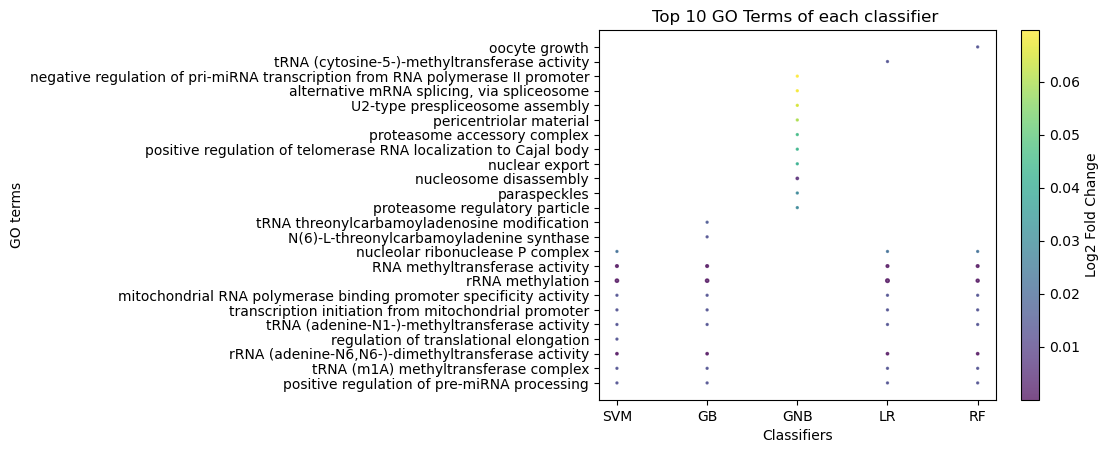

In [22]:

# 绘制气泡图
scatter = plt.scatter(all_report['Classifier'], all_report['Term'], s=all_report['Count'], c=all_report['PAdjust'], alpha=0.7)


# 添加标题和标签
plt.title('Top 10 GO Terms of each classifier ')
plt.xlabel('Classifiers')
plt.ylabel('GO terms')

# 添加颜色图例
colorbar = plt.colorbar(scatter)
colorbar.set_label('Log2 Fold Change')

# 添加大小图例
sizes = [0, 1, 2, 3,4]  # 自定义大小图例的值
labels = [0, 5, 10, 20,50,100]  # 自定义大小图例的标签
legend_sizes = plt.scatter([], [], s=sizes, c='k', alpha=0.5)  # 创建大小图例的空气泡图
legend = plt.legend(legend_sizes, labels, title='Log2 Fold Change', labelspacing=1.2, loc='upper right')
plt.gca().add_artist(legend)

# 显示图形
plt.show()